# Instructions:
1. I have tested GLOVE embeddings + hate words + LSTM model on FormSpring and Youtube dataset

2. To run for a specific dataset, you can directly scroll to that particular data and run the code. For example, if you want to run for the YouTube dataset, you can start running from "2.YouTube Dataset".

3. To run the code, please upload form_spring_clean.csv and utube_clean.csv files provided under clean_data folder.

# 1.Form Spring Dataset

##1.1 Installing dependencies and importing packages

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout,Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import numpy as np
from numpy import array
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1.2 Reading and preparing the dataset

In [2]:
#Reading dataset
df_form= pd.read_csv('form_spring_clean.csv')
df_form.head()

,Text,hate_words,Label,Text_clean,hate_words_clean,category
0,Q: what&#039;s your favorite song? :D<br>A: I ...,0,0,q what039s favorite song d a i like many songs...,0,non_hate_speech
1,Q: <3<br>A: </3 ? haha jk! <33,0,0,q 3 a 3 haha jk 33,0,non_hate_speech
2,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,0,0,q quothey angel duh sexyquot a really thanks haha,0,non_hate_speech
3,Q: (:<br>A: ;(,0,0,q a,0,non_hate_speech
4,Q: ******************MEOWWW*******************...,0,0,q meowww a rawr,0,non_hate_speech


In [3]:
# Grouping data by label
df_form.groupby('Label').count()

,Text,hate_words,Text_clean,hate_words_clean,category
Label,,,,,
0,13616,13616,13616,13507,13616
1,3411,3411,3411,3335,3411


In [4]:
df_form['category'].value_counts()

non_hate_speech    13616
hate_speech         3411
Name: category, dtype: int64

In [5]:
non_hate_speech, hate_speech = np.bincount(df_form['Label'])
total = hate_speech + non_hate_speech
print('Examples:\n    Total: {}\n    non_hate_speech: {} ({:.2f}% of total)\n'.format(
    total, non_hate_speech, 100 *  non_hate_speech / total))
print('Examples:\n    Total: {}\n    hate_speech: {} ({:.2f}% of total)\n'.format(
    total, hate_speech, 100 * hate_speech / total))


Examples:
    Total: 17027
    non_hate_speech: 13616 (79.97% of total)

Examples:
    Total: 17027
    hate_speech: 3411 (20.03% of total)



###1.2.1 Splitting the data between train, validation and test sets

In [6]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df_form.index.values,
    df_form.Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_form.Label.values,    
)

In [7]:
X_train_.shape

(15324,)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    df_form.loc[X_train_].index.values,
    df_form.loc[X_train_].Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_form.loc[X_train_].Label.values,  
)

In [9]:
df_form['data_type'] = ['not_set']*df_form.shape[0]
df_form.loc[X_train, 'data_type'] = 'train'
df_form.loc[X_val, 'data_type'] = 'val'
df_form.loc[X_test, 'data_type'] = 'test'

In [10]:
df_form.groupby(['category', 'Label', 'data_type']).count()

Text  hate_words  Text_clean  \
category        Label data_type                                  
hate_speech     1     test         341         341         341   
                      train       2763        2763        2763   
                      val          307         307         307   
non_hate_speech 0     test        1362        1362        1362   
                      train      11028       11028       11028   
                      val         1226        1226        1226   

                                 hate_words_clean  
category        Label data_type                    
hate_speech     1     test                    336  
                      train                  2700  
                      val                     299  
non_hate_speech 0     test                   1351  
                      train                 10941  
                      val                    1215

In [11]:
df_train = df_form.loc[df_form["data_type"]=="train"]
df_train.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
0,Q: what&#039;s your favorite song? :D<br>A: I ...,0,0,q what039s favorite song d a i like many songs...,0,non_hate_speech,train
1,Q: <3<br>A: </3 ? haha jk! <33,0,0,q 3 a 3 haha jk 33,0,non_hate_speech,train
2,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,0,0,q quothey angel duh sexyquot a really thanks haha,0,non_hate_speech,train
3,Q: (:<br>A: ;(,0,0,q a,0,non_hate_speech,train
6,Q: Apriiiiiiiiiiiill!!! I miss uuuu! It&#039;s...,0,0,q apriiiiiiiiiiiill i miss uuuu it039s emma bt...,0,non_hate_speech,train


In [12]:
df_val = df_form.loc[df_form["data_type"]=="val"]
df_val.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
60,Q: have you ever been on itellyouthat.com? go ...,0,0,q ever itellyouthat com go tell something worl...,0,non_hate_speech,val
75,Q: heyyyyyy!!! how u doin!!!!!<br>A: Im doing ...,0,0,q heyyyyyy u doin a im good thankyuh heyyy hbu,0,non_hate_speech,val
83,Q: i love youu chica!<33<br>A: NO no no! I Lov...,0,0,q love youu chica 33 a no i love youuu moreee3...,0,non_hate_speech,val
106,Q: If you could make one person fall in love w...,0,0,q if could make one person fall love would a m...,0,non_hate_speech,val
112,Q: If you had to cook dinner for someone tonig...,0,0,q if cook dinner someone tonight would make a ...,0,non_hate_speech,val


In [13]:
df_test = df_form.loc[df_form["data_type"]=="test"]
df_test.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,data_type
4,Q: ******************MEOWWW*******************...,0,0,q meowww a rawr,0,non_hate_speech,test
5,Q: any makeup tips? i suck at doing my makeup ...,0,0,q makeup tips suck makeup lol a sure like tell...,0,non_hate_speech,test
9,Q: are you a trusting person?<br>A: Yes veryy ...,0,0,q trusting person a yes veryy trustin person m...,0,non_hate_speech,test
17,Q: Bitch u thee bomb like Tick TICK!<br>A: Hah...,Bitch u thee bomb like Tick TICK,1,q bitch u thee bomb like tick tick a hahah thanks,bitch u thee bomb like tick tick,hate_speech,test
64,Q: Hello bitch! How&#039;s ur day going? Good ...,0,0,q hello bitch how039s ur day going good i hope...,0,non_hate_speech,test


##1.3 GLOVE embeddings pre-processing

In [14]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [15]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-08-14 15:14:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-14 15:14:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-14 15:14:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [17]:
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')
EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

Size of Embedding:  300


In [18]:
len(wordToIndex)

400000

In [19]:
wordToIndex_new = {"<PAD>": 0,"<START>": 1,"<UNK>":2,"<EOS>":3 }
wordToIndex_new.update(wordToIndex)

In [20]:
print(wordToIndex["you"])
print(indexToWord[394475])

394475
you


In [21]:
import copy
def glove_data(data,data2):
  X_data_glove=[]
  X_data_glove_2=[]
  i=0
  for i in range(len(data)):
    X_data_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(data[i]))

  for i in range(len(data2)):
    X_data_glove_2.append(tf.keras.preprocessing.text.text_to_word_sequence(data2[i]))

  X_data_glove_int= copy.deepcopy(X_data_glove)

  for list1 in X_data_glove_int:
    for i in list1:
      if i in wordToIndex_new.keys():
        index = list1.index(i)
        list1[index]=wordToIndex_new.get(i) 
      else:
        index = list1.index(i) #get the index of each word
        list1[index]='<UNK>'#if not in wordToIndex_new replace it with <UNK>
        list1[index]=wordToIndex_new.get(list1[index])  #replace each word with integer present in wordToIndex_new dictionary



  X_data2_glove_int= copy.deepcopy(X_data_glove_2) 

  for list1 in X_data2_glove_int:
    for i in list1:
      if i in wordToIndex_new.keys():
        index = list1.index(i)
        list1[index]=wordToIndex_new.get(i) 
      else:
        index = list1.index(i)
        list1[index]='<UNK>'
        list1[index]=wordToIndex_new.get(list1[index])  

  return (X_data_glove_int,X_data2_glove_int)


In [22]:
df_train_text_list=list(df_train['Text'])
df_train_hate_list=list(df_train['hate_words'])

In [23]:
df_test_text_list=list(df_test['Text'])
df_test_hate_list=list(df_test['hate_words'])

df_val_text_list=list(df_val['Text'])
df_val_hate_list=list(df_val['hate_words'])

In [24]:
x_train_glove,x_train_glove_2=glove_data(df_train_text_list,df_train_hate_list)
x_test_glove,x_test_glove_2=glove_data(df_test_text_list,df_test_hate_list)
x_val_glove,x_val_glove_2=glove_data(df_val_text_list,df_val_hate_list)

In [25]:
import keras
x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=200)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=200)

x_val_pad_glove = keras.preprocessing.sequence.pad_sequences(x_val_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=200)

In [26]:
x_train_pad_glove_2 = keras.preprocessing.sequence.pad_sequences(x_train_glove_2,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=200)

x_test_pad_glove_2 = keras.preprocessing.sequence.pad_sequences(x_test_glove_2,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=200)

x_val_pad_glove_2 = keras.preprocessing.sequence.pad_sequences(x_val_glove_2,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=200)

In [27]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [28]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer_2(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings_2')
    return embeddingLayer

In [29]:
from keras.layers import Lambda, GlobalAveragePooling1D
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

##1.4 GLOVE embeddings + LSTM 

In [30]:
sequence_input = Input(shape=(200,), dtype='int32')
sequence_input2 = Input(shape=(200,), dtype='int32')
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(sequence_input)
embeddingLayer2=createPretrainedEmbeddingLayer_2(wordToGlove,wordToIndex,isTrainable=True)(sequence_input2)
combined=tf.keras.layers.Concatenate()([embeddingLayer, embeddingLayer2])
x = LSTM(60, return_sequences=True,name='lstm_layer')(combined)
x=GlobalAveragePooling1DMasked()(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [31]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [32]:
model = Model([sequence_input,sequence_input2], preds)
model.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   (None, 200, 300)     120000300   ['input_1[0][0]']                
                                                                                                  
 GloVe_Embeddings_2 (Embedding)  (None, 200, 300)    120000300   ['input_2[0][0]']                
                                                                                              

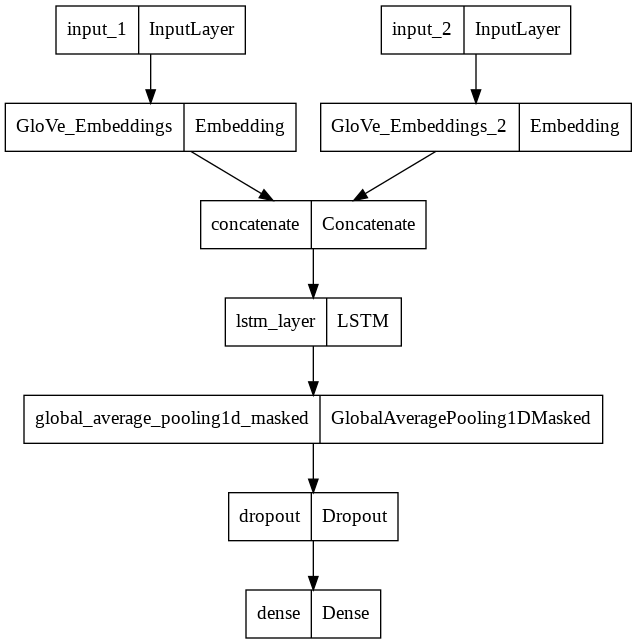

In [33]:
tf.keras.utils.plot_model(model)

In [34]:
y_train=np.array(df_train['Label'])
y_test=np.array(df_test['Label'])
y_val=np.array(df_val['Label'])

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("golve_load_file.h5",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [36]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [37]:
print('Training progress:')
history = model.fit([x_train_pad_glove,x_train_pad_glove_2], 
                    y_train,
                    epochs = 10, 
                    batch_size=32, 
                    callbacks = callbacks,
                    validation_data=([x_val_pad_glove,x_val_pad_glove_2],y_val))

Training progress:
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


431/431 [==============================] - ETA: 0s - loss: 0.1454 - precision: 0.9362 - recall: 0.8342 - TP: 2305.0000
Epoch 1: val_TP improved from -inf to 293.00000, saving model to golve_load_file.h5
431/431 [==============================] - 298s 674ms/step - loss: 0.1454 - precision: 0.9362 - recall: 0.8342 - TP: 2305.0000 - val_loss: 0.0688 - val_precision: 0.9832 - val_recall: 0.9544 - val_TP: 293.0000
Epoch 2/10
431/431 [==============================] - ETA: 0s - loss: 0.0860 - precision: 0.9695 - recall: 0.9425 - TP: 2604.0000
Epoch 2: val_TP did not improve from 293.00000
431/431 [==============================] - 32s 74ms/step - loss: 0.0860 - precision: 0.9695 - recall: 0.9425 - TP: 2604.0000 - val_loss: 0.0712 - val_precision: 0.9799 - val_recall: 0.9511 - val_TP: 292.0000
Epoch 3/10
431/431 [==============================] - ETA: 0s - loss: 0.0787 - precision: 0.9711 - recall: 0.9486 - TP: 2621.0000
Epoch 3: val_TP did not improve from 293.00000
431/431 [================

dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


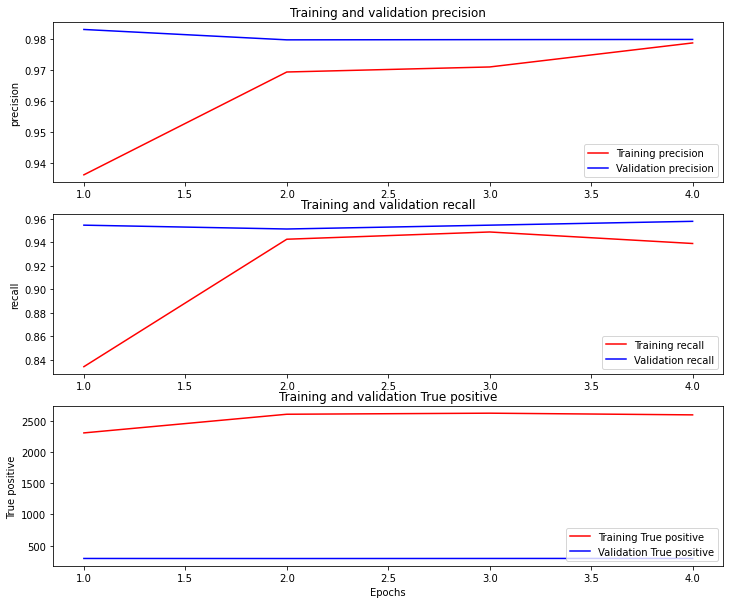

In [38]:
history_dict = history.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
# plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
#plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
results = model.evaluate([x_test_pad_glove,x_test_pad_glove_2],y_test)
print(results)

126/126 [==============================] - 1s 8ms/step - loss: 0.0426 - precision: 0.9686 - recall: 0.9417 - TP: 339.0000
[0.04257204011082649, 0.9685714244842529, 0.9416666626930237, 339.0]


###1.4.1 Results

####1.4.1.1 Predicting

In [39]:
y_pred=model.predict([x_test_pad_glove,x_test_pad_glove_2])
y_pred

array([[0.01843361],
       [0.01385116],
       [0.01565431],
       ...,
       [0.97079515],
       [0.97417974],
       [0.9727208 ]], dtype=float32)

In [40]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [41]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [42]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for GLOVE embeddings + hate words + LSTM in FormSpring Dataset is:',round(result[0],3))
print('Recall for GLOVE embeddings + hate words +LSTM in FormSpring Dataset is:',round(result[1],3))
print('macro F1 score for GLOVE embeddings + hate words +LSTM in FormSpring Dataset is:',round(result[2],3))

Precision for GLOVE embeddings + hate words + LSTM in FormSpring Dataset is: 0.979
Recall for GLOVE embeddings + hate words +LSTM in FormSpring Dataset is: 0.967
macro F1 score for GLOVE embeddings + hate words +LSTM in FormSpring Dataset is: 0.973


In [43]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_mod, average='macro')

0.973088816658811

###1.4.2 Confusion Matrix

In [44]:
def matrix_per(cf_matrix):
  group_percentages_list=[]
  k=cf_matrix.flatten()
  for i in range(0,len(cf_matrix.flatten())):
    if i == 0 or i == 1:
      group_percentages_list.append(k[i]/(k[0] + k[1]))
    else:
      group_percentages_list.append(k[i]/(k[2] + k[3]))
  return group_percentages_list

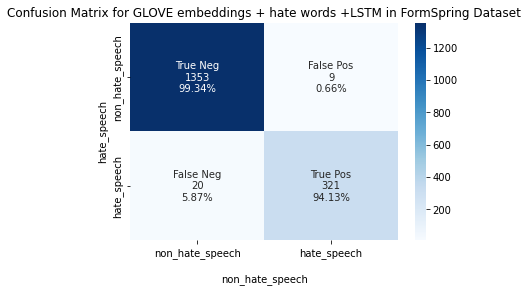

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for GLOVE embeddings + hate words +LSTM in FormSpring Dataset');
ax.set_xlabel('\nnon_hate_speech')
ax.set_ylabel('hate_speech');


ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()

# 2.YouTube Dataset

##2.1 Installing dependencies and importing packages

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout,Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import numpy as np
from numpy import array
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##2.2. Reading and preparing the dataset

In [2]:
#Reading dataset
df_utube= pd.read_csv('utube_clean.csv')
df_utube.head()

,Text,hate_words,Label,Text_clean,hate_words_clean,category
0,Does N.e.bodyelse Hear her Crazy ass Screamin ...,0,0,does n e bodyelse hear crazy ass screamin hoe ...,0,non_hate_speech
1,There are so many things that are incorrect wi...,0,0,there many things incorrect comment unbelievab...,0,non_hate_speech
2,3:26 hahah my boyfriend showed this song to me...,0,0,326 hahah boyfriend showed song i love me tooo...,0,non_hate_speech
3,dick beyonce fuck y a ass hole you are truely ...,"""""dick beyonce fuck y a ass hole you are truel...",1,dick beyonce fuck ass hole truely dog bitch ph...,dick beyonce fuck ass hole truely dog bitch ma...,hate_speech
4,DongHaeTaemin and Kai ;A; luhansehun and bacon...,0,0,donghaetaemin kai a luhansehun bacon xd taemin...,0,non_hate_speech


In [3]:
df_utube['category']=df_utube['Label'].map({0: 'non_hate_speech', 1: 'hate_speech'})

df_utube

,Text,hate_words,Label,Text_clean,hate_words_clean,category
0,Does N.e.bodyelse Hear her Crazy ass Screamin ...,0,0,does n e bodyelse hear crazy ass screamin hoe ...,0,non_hate_speech
1,There are so many things that are incorrect wi...,0,0,there many things incorrect comment unbelievab...,0,non_hate_speech
2,3:26 hahah my boyfriend showed this song to me...,0,0,326 hahah boyfriend showed song i love me tooo...,0,non_hate_speech
3,dick beyonce fuck y a ass hole you are truely ...,"""""dick beyonce fuck y a ass hole you are truel...",1,dick beyonce fuck ass hole truely dog bitch ph...,dick beyonce fuck ass hole truely dog bitch ma...,hate_speech
4,DongHaeTaemin and Kai ;A; luhansehun and bacon...,0,0,donghaetaemin kai a luhansehun bacon xd taemin...,0,non_hate_speech
...,...,...,...,...,...,...
3455,She pretty I love this song I miss the old kel...,0,0,she pretty i love song i miss old kelly ok rih...,0,non_hate_speech
3456,Status-Online Im ZxkillergirlzX! I'm Zxkillerg...,0,0,statusonline im zxkillergirlzx im zxkillergirl...,0,non_hate_speech
3457,JR so cute EXO M Better I agree like yeah yeah...,0,0,jr cute exo m better i agree like yeah yeah ye...,0,non_hate_speech
3458,! !,0,0,NaN,0,non_hate_speech


In [4]:
# Grouping data by label
df_utube.groupby('Label').count()

,Text,hate_words,Text_clean,hate_words_clean,category
Label,,,,,
0,3144,3144,3139,3144,3144
1,316,316,316,316,316


In [5]:
df_utube['category'].value_counts()

non_hate_speech    3144
hate_speech         316
Name: category, dtype: int64

In [6]:
non_hate_speech, hate_speech = np.bincount(df_utube['Label'])
total = hate_speech + non_hate_speech
print('Examples:\n    Total: {}\n    non_hate_speech: {} ({:.2f}% of total)\n'.format(
    total, non_hate_speech, 100 *  non_hate_speech / total))
print('Examples:\n    Total: {}\n    hate_speech: {} ({:.2f}% of total)\n'.format(
    total, hate_speech, 100 * hate_speech / total))


Examples:
    Total: 3460
    non_hate_speech: 3144 (90.87% of total)

Examples:
    Total: 3460
    hate_speech: 316 (9.13% of total)



In [7]:
weight_for_0 = (1 / non_hate_speech)*(total)/2.0 
weight_for_1 = (1 / hate_speech)*(total)/2.0


class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.47


In [8]:
strSer = df_utube['Text_clean'].str
df_utube['word_count']=df_utube['Text_clean'].str.split().str.len()


In [9]:
df_utube.shape

(3460, 7)

In [10]:
df_utube.loc[(df_utube['word_count'] > 500) & (df_utube['category']=='hate_speech')]

,Text,hate_words,Label,Text_clean,hate_words_clean,category,word_count
106,Since when is Dick Cheney a pastor? Question: ...,"""""fuck you"""",""""fucktard now go choke on an AID...",1,since dick cheney pastor question is south lon...,fuck fucktard go choke aids positive cocks fun...,hate_speech,547.0
256,its not his fault wenger was to stingy to take...,"""""u faggot"""",""""dick face"""",""""SO SUCK DICK MOTH...",1,fault wenger stingy take nandos hahaha case ro...,u faggot dick face so suck dick motherfucker c...,hate_speech,552.0
616,lol its great I love it those girls had a chan...,"""""This lady is a fucking phyco"""",""""fucking idi...",1,lol great i love girls chance go kid now hes g...,this lady fucking phyco fucking idiots gay peo...,hate_speech,871.0
669,And MSNBC is not? Tell the truth now.... Actua...,"""""Fuckin morons"""",""""Apologize bitch or we kill...",1,and msnbc tell truth actually it took month ev...,fuckin morons apologize bitch kill steven kay ...,hate_speech,541.0
728,I was so waiting for her to rub her blue hand ...,""""" Fat people are gross"""",""""fatass ugly scumba...",1,i waiting rub blue hand face fat people gross ...,fat people gross fatass ugly scumbag people di...,hate_speech,533.0
780,Even if you don't believe in a higher power. P...,"""""pussy ass"""","""" nigga"""",""""Fuck My Life"""",""""yo...",1,even dont believe higher power praying means w...,pussy ass nigga fuck my life youre retarded so...,hate_speech,608.0
1057,That fat sec guard prolly listens to gay ass t...,"""""fagsmack"""",""""dick riding"""",""""go kill yoursel...",1,that fat sec guard prolly listens gay ass tool...,fagsmack dick riding go kill nigga asshole dum...,hate_speech,617.0
1223,Intellectually Stimulating - I learned somethi...,"""""pissing dick they are""""",1,intellectually stimulating i learned something...,pissing dick,hate_speech,595.0
1316,that's a a dimebag signature series bro you do...,"""""fucking attention whore"""",""""gay ass""""",1,thats dimebag signature series bro dont make f...,fucking attention whore gay ass,hate_speech,556.0
1337,Very cool. The 3D effect is super They make me...,"""""obnoxious pain-in-the-arse entitled bitches ...",1,very cool the 3d effect super they make ill th...,obnoxious paininthearse entitled bitches insan...,hate_speech,607.0


###2.2.1 Splitting the data between train, validation and test sets

In [11]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df_utube.index.values,
    df_utube.Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_utube.Label.values,    
)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    df_utube.loc[X_train_].index.values,
    df_utube.loc[X_train_].Label.values,
    test_size=0.10,
    random_state=42,
    stratify=df_utube.loc[X_train_].Label.values,  
)

In [13]:
df_utube['data_type'] = ['not_set']*df_utube.shape[0]
df_utube.loc[X_train, 'data_type'] = 'train'
df_utube.loc[X_val, 'data_type'] = 'val'
df_utube.loc[X_test, 'data_type'] = 'test'

In [14]:
df_utube.groupby(['category', 'Label', 'data_type']).count()

Text  hate_words  Text_clean  \
category        Label data_type                                 
hate_speech     1     test         32          32          32   
                      train       256         256         256   
                      val          28          28          28   
non_hate_speech 0     test        314         314         313   
                      train      2546        2546        2543   
                      val         284         284         283   

                                 hate_words_clean  word_count  
category        Label data_type                                
hate_speech     1     test                     32          32  
                      train                   256         256  
                      val                      28          28  
non_hate_speech 0     test                    314         313  
                      train                  2546        2543  
                      val                     284         283

In [15]:
df_train = df_utube.loc[df_utube["data_type"]=="train"]
df_train.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,word_count,data_type
0,Does N.e.bodyelse Hear her Crazy ass Screamin ...,0,0,does n e bodyelse hear crazy ass screamin hoe ...,0,non_hate_speech,67.0,train
4,DongHaeTaemin and Kai ;A; luhansehun and bacon...,0,0,donghaetaemin kai a luhansehun bacon xd taemin...,0,non_hate_speech,62.0,train
5,jejus lindos de maiss carlos canta um ritmo ma...,0,0,jejus lindos de maiss carlos canta um ritmo ma...,0,non_hate_speech,66.0,train
6,Ale pajac,0,0,ale pajac,0,non_hate_speech,2.0,train
8,nicki's too sexy holy hell oh. my. god. DON'T ...,0,0,nickis sexy holy hell oh god dont turn my musi...,0,non_hate_speech,45.0,train


In [16]:
df_val = df_utube.loc[df_utube["data_type"]=="val"]
df_val.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,word_count,data_type
2,3:26 hahah my boyfriend showed this song to me...,0,0,326 hahah boyfriend showed song i love me tooo...,0,non_hate_speech,23.0,val
7,"How's ,freedom, working out for you? Still liv...",0,0,hows freedom working still living foreign aid ...,0,non_hate_speech,208.0,val
16,i like that song cool video but i hated the bl...,0,0,like song cool video hated black spots kept co...,0,non_hate_speech,20.0,val
22,Osama Bin Ladin vs. Satan Note to self: Play t...,0,0,osama bin ladin vs satan note self play turbo ...,0,non_hate_speech,248.0,val
25,Monkey D. Ruffy *-*Tolles Video :)! Wow! Toll ...,0,0,monkey d ruffy tolles video wow toll gemacht e...,0,non_hate_speech,45.0,val


In [17]:
df_test = df_utube.loc[df_utube["data_type"]=="test"]
df_test.head(5)

,Text,hate_words,Label,Text_clean,hate_words_clean,category,word_count,data_type
1,There are so many things that are incorrect wi...,0,0,there many things incorrect comment unbelievab...,0,non_hate_speech,66.0,test
3,dick beyonce fuck y a ass hole you are truely ...,"""""dick beyonce fuck y a ass hole you are truel...",1,dick beyonce fuck ass hole truely dog bitch ph...,dick beyonce fuck ass hole truely dog bitch ma...,hate_speech,108.0,test
24,She is so cute and I like this song but why di...,0,0,she cute i like song u shave hair you r pretty...,0,non_hate_speech,90.0,test
38,I put that yesterday Thumbs Up if you got here...,0,0,i put yesterday thumbs up got scary montage cl...,0,non_hate_speech,172.0,test
72,this sucks... why only big arms ? fake Its fun...,0,0,sucks big arms fake its funny fat black widow ...,0,non_hate_speech,135.0,test


##2.3 GLOVE embeddings pre-processing

In [18]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [19]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-08-05 19:26:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-05 19:26:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-05 19:26:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [20]:
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')
EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

Size of Embedding:  300


In [21]:
len(wordToIndex)

400000

In [22]:
wordToIndex_new = {"<PAD>": 0,"<START>": 1,"<UNK>":2,"<EOS>":3 }
wordToIndex_new.update(wordToIndex)

In [23]:
import copy
def glove_data(data,data2):
  X_data_glove=[]
  X_data_glove_2=[]
  i=0
  for i in range(len(data)):
    X_data_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(data[i]))

  for i in range(len(data2)):
    X_data_glove_2.append(tf.keras.preprocessing.text.text_to_word_sequence(data2[i]))

  X_data_glove_int= copy.deepcopy(X_data_glove)

  for list1 in X_data_glove_int:
    for i in list1:
      if i in wordToIndex_new.keys():
        index = list1.index(i)
        list1[index]=wordToIndex_new.get(i) 
      else:
        index = list1.index(i) #get the index of each word
        list1[index]='<UNK>'#if not in wordToIndex_new replace it with <UNK>
        list1[index]=wordToIndex_new.get(list1[index])  #replace each word with integer present in wordToIndex_new dictionary



  X_data2_glove_int= copy.deepcopy(X_data_glove_2) 

  for list1 in X_data2_glove_int:
    for i in list1:
      if i in wordToIndex_new.keys():
        index = list1.index(i)
        list1[index]=wordToIndex_new.get(i) 
      else:
        index = list1.index(i)
        list1[index]='<UNK>'
        list1[index]=wordToIndex_new.get(list1[index])  

  return (X_data_glove_int,X_data2_glove_int)


In [24]:
df_train_text_list=list(df_train['Text'])
df_train_hate_list=list(df_train['hate_words'])

In [25]:
df_test_text_list=list(df_test['Text'])
df_test_hate_list=list(df_test['hate_words'])

df_val_text_list=list(df_val['Text'])
df_val_hate_list=list(df_val['hate_words'])

In [26]:
x_train_glove,x_train_glove_2=glove_data(df_train_text_list,df_train_hate_list)
x_test_glove,x_test_glove_2=glove_data(df_test_text_list,df_test_hate_list)
x_val_glove,x_val_glove_2=glove_data(df_val_text_list,df_val_hate_list)

In [27]:
import keras
x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=500)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=500)

x_val_pad_glove = keras.preprocessing.sequence.pad_sequences(x_val_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=500)

In [28]:
x_train_pad_glove_2 = keras.preprocessing.sequence.pad_sequences(x_train_glove_2,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=500)

x_test_pad_glove_2 = keras.preprocessing.sequence.pad_sequences(x_test_glove_2,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=500)

x_val_pad_glove_2 = keras.preprocessing.sequence.pad_sequences(x_val_glove_2,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=500)

In [29]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [30]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer_2(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings_2')
    return embeddingLayer

In [31]:
from keras.layers import Lambda, GlobalAveragePooling1D
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

##2.4 GLOVE embeddings + LSTM 

In [33]:
sequence_input = Input(shape=(500,), dtype='int32')
sequence_input2 = Input(shape=(500,), dtype='int32')
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(sequence_input)
embeddingLayer2=createPretrainedEmbeddingLayer_2(wordToGlove,wordToIndex,isTrainable=True)(sequence_input2)
combined=tf.keras.layers.Concatenate()([embeddingLayer, embeddingLayer2])
x = LSTM(60, return_sequences=True,name='lstm_layer')(combined)
x=GlobalAveragePooling1DMasked()(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid",kernel_regularizer='l2')(x)

In [34]:
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.TruePositives(name='TP')
]

In [35]:
model = Model([sequence_input,sequence_input2], preds)
model.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   (None, 500, 300)     120000300   ['input_1[0][0]']                
                                                                                                  
 GloVe_Embeddings_2 (Embedding)  (None, 500, 300)    120000300   ['input_2[0][0]']                
                                                                                              

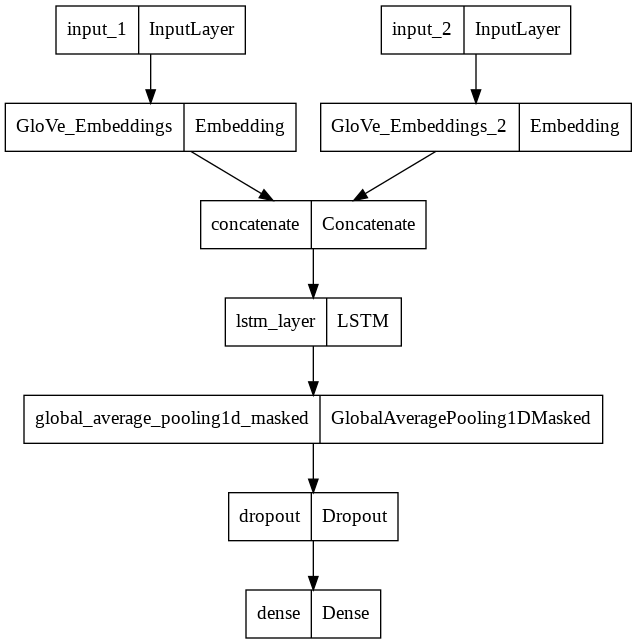

In [36]:
tf.keras.utils.plot_model(model)

In [37]:
y_train=np.array(df_train['Label'])
y_test=np.array(df_test['Label'])
y_val=np.array(df_val['Label'])

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("golve_load_file_utube.h5",
                             monitor="val_TP",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [39]:
earlystop = EarlyStopping(monitor = 'val_TP', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 2, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [40]:
print('Training progress:')
history = model.fit([x_train_pad_glove,x_train_pad_glove_2], 
                    y_train,
                    class_weight=class_weights,
                    epochs = 10, 
                    batch_size=32, 
                    callbacks = callbacks,
                    validation_data=([x_val_pad_glove,x_val_pad_glove_2],y_val))

Training progress:
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - ETA: 0s - loss: 0.6052 - precision: 0.1895 - recall: 0.6875 - TP: 176.0000
Epoch 1: val_TP improved from -inf to 25.00000, saving model to golve_load_file_utube.h5
88/88 [==============================] - 188s 2s/step - loss: 0.6052 - precision: 0.1895 - recall: 0.6875 - TP: 176.0000 - val_loss: 0.7078 - val_precision: 0.5208 - val_recall: 0.8929 - val_TP: 25.0000
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.1047 - precision: 0.9653 - recall: 0.9766 - TP: 250.0000
Epoch 2: val_TP did not improve from 25.00000
88/88 [==============================] - 8s 90ms/step - loss: 0.1047 - precision: 0.9653 - recall: 0.9766 - TP: 250.0000 - val_loss: 0.0768 - val_precision: 1.0000 - val_recall: 0.8929 - val_TP: 25.0000
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.0701 - precision: 1.0000 - recall: 0.9805 - TP: 251.0000Restoring model weights from the end of the best epoch: 1.

Epoch 3: val_TP did not improv

dict_keys(['loss', 'precision', 'recall', 'TP', 'val_loss', 'val_precision', 'val_recall', 'val_TP'])


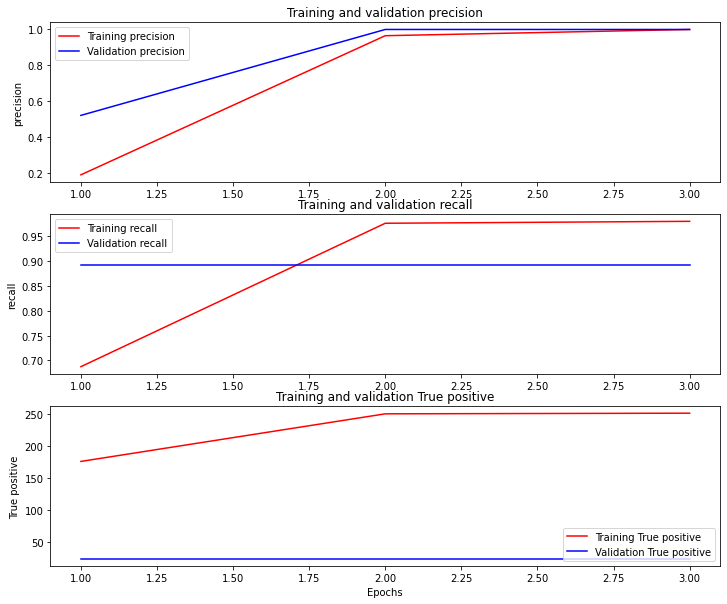

In [41]:
history_dict = history.history
print(history_dict.keys())

TP = history_dict['TP']
val_TP = history_dict['val_TP']
precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

epochs = range(1, len(TP) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
# plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(3, 1, 2)
# "bo" is for "blue dot"
plt.plot(epochs, recall, 'r', label='Training recall')
# b is for "solid blue line"
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
#plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, TP, 'r', label='Training True positive')
plt.plot(epochs, val_TP, 'b', label='Validation True positive')
plt.title('Training and validation True positive')
plt.xlabel('Epochs')
plt.ylabel('True positive')
plt.legend(loc='lower right')

In [ ]:
from keras.models import load_model
model = tf.keras.models.load_model(('golve_load_file_utube.h5'),custom_objects={'GlobalAveragePooling1DMasked': GlobalAveragePooling1DMasked})

###2.4.1 Results

####2.4.1.1 Predicting

In [ ]:
y_pred=model.predict([x_test_pad_glove,x_test_pad_glove_2])
y_pred

In [43]:
y_pred_mod=[]
for i in y_pred.tolist():
  for k in i:
    y_pred_mod.append(k)

In [44]:
for i in range(len(y_pred_mod)):
  if y_pred_mod[i] <= float(0.5):
    y_pred_mod[i]= 0
  else:
    y_pred_mod[i]=1

In [48]:
from sklearn.metrics import precision_recall_fscore_support
result=precision_recall_fscore_support(y_test, y_pred_mod, average='macro')
print('Precision for GLOVE embeddings + hate words + LSTM in YouTube Dataset is:',round(result[0],3))
print('Recall for GLOVE embeddings + hate words +LSTM in YouTube Dataset is:',round(result[1],3))
print('macro F1 score for GLOVE embeddings + hate words +LSTM in YouTube Dataset is:',round(result[2],3))

Precision for GLOVE embeddings + hate words + LSTM in YouTube Dataset is: 0.781
Recall for GLOVE embeddings + hate words +LSTM in YouTube Dataset is: 0.96
macro F1 score for GLOVE embeddings + hate words +LSTM in YouTube Dataset is: 0.839


In [49]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_mod, average='macro')

0.8388208768889635

###2.4.2 Confusion Matrix

In [50]:
def matrix_per(cf_matrix):
  group_percentages_list=[]
  k=cf_matrix.flatten()
  for i in range(0,len(cf_matrix.flatten())):
    if i == 0 or i == 1:
      group_percentages_list.append(k[i]/(k[0] + k[1]))
    else:
      group_percentages_list.append(k[i]/(k[2] + k[3]))
  return group_percentages_list

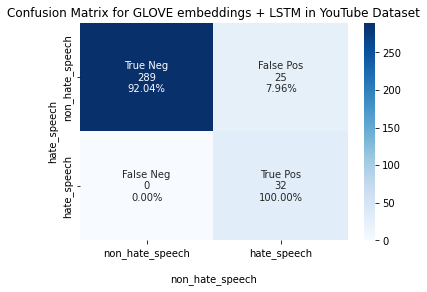

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf_matrix=confusion_matrix(y_test, y_pred_mod)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_per(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix for GLOVE embeddings + LSTM in YouTube Dataset');
ax.set_xlabel('\nnon_hate_speech')
ax.set_ylabel('hate_speech');

ax.xaxis.set_ticklabels(['non_hate_speech','hate_speech'])
ax.yaxis.set_ticklabels(['non_hate_speech','hate_speech'])

## Display the visualization of the Confusion Matrix.
plt.show()